# Fine Tune
- RoBERTa
- No need for inference speed up using distil bert since dataset is very small
- Hyperparameter tuning using huggingfaces hyperparameter search
- group k fold cross validation for prediction

## Several conditions:
- (spell corrected and) expanded prompts
- raw conversational part


In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")


Using GPU: NVIDIA A100-SXM4-80GB


In [2]:
#import sqlite3
import pandas as pd
from google.colab import files

files.upload()


#conn  = sqlite3.connect('../../giicg.db')
#all_prompts = pd.read_sql("Select * from expanded_roberta_prompts", conn)
#conn.close()
all_prompts = pd.read_csv('expanded_roberta_prompts.csv')


Saving expanded_roberta_prompts.csv to expanded_roberta_prompts.csv


## Check data

In [3]:
users_per_gender = all_prompts.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
users_per_gender

,gender,num_users
0,Man (cisgender),15
1,Woman (cisgender),13


In [4]:
messages_per_user = all_prompts.groupby('user_id')['message_id'].nunique().reset_index(name='num_messages')
messages_per_user

,user_id,num_messages
0,6,9
1,8,2
2,11,11
3,15,3
4,16,25
5,25,4
6,28,22
7,29,2
8,31,5
9,34,66


## Set up Model

In [5]:
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support


files.upload()

with open("label2id.json", "r") as f:
    label2id = json.load(f)


model_name = "roberta-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)


num_labels = len(label2id)

def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels,
    )

    return model

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_function(examples):
    return tokenizer(
        examples["conversational"], # use the masked prompts
        truncation=True,
        padding=False # padding is handled in the data collator
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    acc = accuracy_score(labels, preds)

    # Get per-class metrics & support
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average=None)
    precision_w = precision_recall_fscore_support(labels, preds, average='weighted')[0]
    recall_w    = precision_recall_fscore_support(labels, preds, average='weighted')[1]
    f1_w        = precision_recall_fscore_support(labels, preds, average='weighted')[2]

    num_classes = len(precision)

    metrics = {
        'accuracy': acc,
        'precision_weighted': precision_w,
        'recall_weighted': recall_w,
        'f1_weighted': f1_w,
    }

    for i in range(num_classes):
        metrics[f'precision_class_{i}'] = precision[i]
        metrics[f'recall_class_{i}'] = recall[i]
        metrics[f'f1_class_{i}'] = f1[i]
        metrics[f'support_class_{i}'] = support[i]

    return metrics



Saving label2id.json to label2id.json


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## Check max sample size

In [6]:
texts = all_prompts['conversational'].tolist()

token_counts = [len(tokenizer.encode(text, truncation=True)) for text in texts]

max_tokens = max(token_counts)
min_tokens = min(token_counts)
avg_tokens = sum(token_counts) / len(token_counts)

print(f"Max tokens: {max_tokens}")
print(f"Min tokens: {min_tokens}")


Max tokens: 407
Min tokens: 4


# ECE


In [7]:

def expected_calibration_error(y_true, y_prob, n_bins=15, strategy="uniform"):
    """
    Compute Expected Calibration Error (ECE).
    Parameters:
      y_true: array-like of shape (n_samples,), binary labels {0,1}
      y_prob: array-like of shape (n_samples,), predicted probability for the positive class
      n_bins: number of bins
      strategy: "uniform" (equal-width bins) or "quantile" (equal-size bins)
    Returns:
      float ECE
    """
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    if strategy == "uniform":
        bins = np.linspace(0.0, 1.0, n_bins + 1)
    elif strategy == "quantile":
        # Quantile binning based on predicted probabilities
        bins = np.quantile(y_prob, np.linspace(0.0, 1.0, n_bins + 1))
        # Ensure coverage of [0,1]
        bins[0], bins[-1] = 0.0, 1.0
        # Handle potential identical bin edges due to ties
        bins = np.unique(bins)
        # In rare cases unique quantiles < n_bins+1; fall back to uniform
        if bins.size < 3:
            bins = np.linspace(0.0, 1.0, n_bins + 1)
    else:
        raise ValueError("strategy must be 'uniform' or 'quantile'")

    # Assign each prob to a bin index in [0, n_bins-1]
    bin_indices = np.digitize(y_prob, bins[1:-1], right=True)

    ece = 0.0
    N = y_true.size
    for b in range(len(bins) - 1):
        mask = (bin_indices == b)
        n_b = np.sum(mask)
        if n_b == 0:
            continue
        acc_b = np.mean(y_true[mask])
        conf_b = np.mean(y_prob[mask])
        ece += (n_b / N) * abs(acc_b - conf_b)
    return float(ece)

## Cross Validation

- selected hyperparameters: lr 3.2e-5, batchsizes 8, epochs 5

In [8]:
import numpy as np
from collections import defaultdict, Counter

def stratified_group_k_fold(X, y, groups, n_splits, random_state=None):
    """
    Custom stratified group K-Fold splitter.
    Each group is assigned to a split, trying to balance the class distribution.
    """
    rng = np.random.RandomState(random_state)
    # Get unique groups and their indices
    unique_groups = np.unique(groups)
    rng.shuffle(unique_groups)

    # Build group -> indices map and group -> y count
    group_to_indices = defaultdict(list)
    group_label_counts = dict()
    for idx, group in enumerate(groups):
        group_to_indices[group].append(idx)
    for group in unique_groups:
        ys = y[[i for i in group_to_indices[group]]]
        group_label_counts[group] = Counter(ys)

    # Assign groups to folds
    folds = [[] for _ in range(n_splits)]
    fold_counts = [Counter() for _ in range(n_splits)]

    # Sort groups by the **largest proportion of the rarest class** for best balancing
    class_ratios = []
    for group in unique_groups:
        counts = group_label_counts[group]
        ratios = [counts[c] / sum(counts.values()) for c in set(y)]
        class_ratios.append((min(ratios), group))
    sorted_groups = [g for _, g in sorted(class_ratios, reverse=True)]

    for group in sorted_groups:
        # Choose the fold with the least samples of this group's dominant class
        group_counts = group_label_counts[group]
        dominant_class = max(group_counts, key=group_counts.get)
        min_fold = np.argmin([fc[dominant_class] for fc in fold_counts])
        folds[min_fold].append(group)
        fold_counts[min_fold] += group_counts

    # Yield indices for each fold
    for fold in range(n_splits):
        test_groups = folds[fold]
        test_indices = [i for g in test_groups for i in group_to_indices[g]]
        train_indices = [i for i in range(len(groups)) if groups[i] not in test_groups]
        yield np.array(train_indices), np.array(test_indices)

In [10]:

groups = np.array(all_prompts['user_id'].values)
texts = all_prompts['conversational'].tolist()
labels = np.array(all_prompts['label'].tolist())
n_splits = 5  # e.g. 5-fold CV

#gkf = GroupKFold(n_splits=n_splits)

# Example usage:
#Suppose you have X, y, groups defined
n_splits = 5
for train_idx, test_idx in stratified_group_k_fold(texts, labels, groups, n_splits, random_state=42):
     print("Train fold label counts:", np.bincount(labels[train_idx]))
     print("Test fold label counts:", np.bincount(labels[test_idx]))

for fold, (train_idx, test_idx) in enumerate(stratified_group_k_fold(texts, labels, groups, n_splits, random_state=42)):
    train_user_ids = set(groups[train_idx])
    test_user_ids = set(groups[test_idx])

    print(f"Fold {fold + 1}")
    print(f"Train user_ids ({len(train_user_ids)}): {sorted(train_user_ids)}")
    print(f"Test user_ids ({len(test_user_ids)}): {sorted(test_user_ids)}")

    # Check for overlap
    overlap = test_user_ids & train_user_ids
    if overlap:
        print(f"WARNING: The following user_ids are in both train and test split: {sorted(overlap)}")
    else:
        print("PASS: No test user_ids are present in the train split.")
    print()


Train fold label counts: [254 208]
Test fold label counts: [28 46]
Train fold label counts: [201 198]
Test fold label counts: [81 56]
Train fold label counts: [246 193]
Test fold label counts: [36 61]
Train fold label counts: [201 211]
Test fold label counts: [81 43]
Train fold label counts: [226 206]
Test fold label counts: [56 48]
Fold 1
Train user_ids (21): [np.int64(6), np.int64(8), np.int64(16), np.int64(25), np.int64(28), np.int64(29), np.int64(31), np.int64(34), np.int64(46), np.int64(47), np.int64(55), np.int64(56), np.int64(63), np.int64(65), np.int64(73), np.int64(79), np.int64(81), np.int64(83), np.int64(88), np.int64(89), np.int64(91)]
Test user_ids (7): [np.int64(11), np.int64(15), np.int64(48), np.int64(60), np.int64(77), np.int64(90), np.int64(92)]
PASS: No test user_ids are present in the train split.

Fold 2
Train user_ids (25): [np.int64(6), np.int64(8), np.int64(11), np.int64(15), np.int64(25), np.int64(28), np.int64(29), np.int64(31), np.int64(34), np.int64(46), np.

In [28]:

from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
from sklearn.model_selection import GroupKFold
from scipy.special import softmax
import numpy as np




all_results = []
all_train_results = []
all_probs = []
all_true = []

for fold, (train_idx, val_idx) in enumerate(stratified_group_k_fold(texts, labels, groups, n_splits, random_state=42)):
    print(f"Fold {fold + 1}")

    train_prompts = all_prompts.iloc[train_idx]
    val_prompts = all_prompts.iloc[val_idx]

    train_dataset = Dataset.from_pandas(train_prompts[['conversational', 'label']])
    val_dataset = Dataset.from_pandas(val_prompts[['conversational', 'label']])

    train_dataset = train_dataset.map(tokenize_function, batched=True)
    val_dataset = val_dataset.map(tokenize_function, batched=True)

    # Set up Trainer with model/tokenizer/data_collator as before
    trainer = Trainer(
        model_init=model_init,
        args=TrainingArguments(
            output_dir=f"./finetune/cross_validation/fold_{fold+1}_results",
            eval_strategy="epoch",
            save_strategy="epoch",
            logging_dir=f"./fold_{fold+1}_logs",
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            num_train_epochs=5,
            learning_rate=1.2e-5,
            # ohne weight decay accuracy 60
            #weight_decay=0.05, accuracy 58
            #weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="accuracy",
            logging_steps=50,
            logging_strategy="steps",
            report_to="none",
        ),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
        compute_metrics=compute_metrics,
    )

    trainer.train()
    eval_metrics = trainer.evaluate()
    print(f"Fold {fold + 1} metrics:", eval_metrics)

    trainer.train()  # Train
    train_metrics = trainer.evaluate(eval_dataset=train_dataset)  # Evaluate on train set for training metrics
    print(f"Fold {fold + 1} train accuracy:", train_metrics)

    # Get predictions on validation set
    outputs = trainer.predict(val_dataset)
    y_true = outputs.label_ids

    # If binary classification, logits.shape = (n, 2) for [class0, class1]
    # Prob: use softmax for multiclass or sigmoid for single logit
    y_logits = outputs.predictions

    # For binary classification with two logits (per sample)
    y_prob = softmax(y_logits, axis=1)[:, 1]

    # Save for this fold
    all_probs.append(y_prob)
    all_true.append(y_true)

    all_results.append(eval_metrics)
    all_train_results.append(train_metrics)

print(all_results)
print("train metrics\n")
print(all_train_results)

pooled_true = np.concatenate(all_true)
pooled_probs = np.concatenate(all_probs)
pooled_ece = expected_calibration_error(pooled_true, pooled_probs)
print("Pooled ECE across all folds:", pooled_ece)





Fold 1


Map:   0%|          | 0/462 [00:00<?, ? examples/s]

Map:   0%|          | 0/74 [00:00<?, ? examples/s]

/tmp/ipython-input-930429151.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.688700,0.719474,0.378378,0.143170,0.378378,0.207737,0.378378,1.000000,0.549020,28,0.000000,0.000000,0.000000,46
2,0.594200,1.053159,0.513514,0.569206,0.513514,0.516358,0.409091,0.642857,0.500000,28,0.666667,0.434783,0.526316,46
3,0.372400,1.296499,0.554054,0.583638,0.554054,0.560749,0.432432,0.571429,0.492308,28,0.675676,0.543478,0.602410,46
4,0.255600,1.585228,0.513514,0.533188,0.513514,0.520083,0.382353,0.464286,0.419355,28,0.625000,0.543478,0.581395,46
5,0.212600,1.675393,0.513514,0.533188,0.513514,0.520083,0.382353,0.464286,0.419355,28,0.625000,0.543478,0.581395,46


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 1 metrics: {'eval_loss': 1.296499252319336, 'eval_accuracy': 0.5540540540540541, 'eval_precision_weighted': 0.5836376917457999, 'eval_recall_weighted': 0.5540540540540541, 'eval_f1_weighted': 0.5607494426771535, 'eval_precision_class_0': 0.43243243243243246, 'eval_recall_class_0': 0.5714285714285714, 'eval_f1_class_0': 0.49230769230769234, 'eval_support_class_0': 28, 'eval_precision_class_1': 0.6756756756756757, 'eval_recall_class_1': 0.5434782608695652, 'eval_f1_class_1': 0.6024096385542169, 'eval_support_class_1': 46, 'eval_runtime': 0.1305, 'eval_samples_per_second': 567.261, 'eval_steps_per_second': 76.657, 'epoch': 5.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.688700,0.719474,0.378378,0.143170,0.378378,0.207737,0.378378,1.000000,0.549020,28,0.000000,0.000000,0.000000,46
2,0.594200,1.053131,0.513514,0.569206,0.513514,0.516358,0.409091,0.642857,0.500000,28,0.666667,0.434783,0.526316,46
3,0.372400,1.296464,0.554054,0.583638,0.554054,0.560749,0.432432,0.571429,0.492308,28,0.675676,0.543478,0.602410,46
4,0.255600,1.585221,0.513514,0.533188,0.513514,0.520083,0.382353,0.464286,0.419355,28,0.625000,0.543478,0.581395,46
5,0.212600,1.675338,0.513514,0.533188,0.513514,0.520083,0.382353,0.464286,0.419355,28,0.625000,0.543478,0.581395,46


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 1 train accuracy: {'eval_loss': 0.1779935210943222, 'eval_accuracy': 0.9264069264069265, 'eval_precision_weighted': 0.9265031265031266, 'eval_recall_weighted': 0.9264069264069265, 'eval_f1_weighted': 0.9264375455346956, 'eval_precision_class_0': 0.9365079365079365, 'eval_recall_class_0': 0.9291338582677166, 'eval_f1_class_0': 0.932806324110672, 'eval_support_class_0': 254, 'eval_precision_class_1': 0.9142857142857143, 'eval_recall_class_1': 0.9230769230769231, 'eval_f1_class_1': 0.9186602870813397, 'eval_support_class_1': 208, 'eval_runtime': 0.7246, 'eval_samples_per_second': 637.608, 'eval_steps_per_second': 80.046, 'epoch': 5.0}
Fold 2


Map:   0%|          | 0/399 [00:00<?, ? examples/s]

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

/tmp/ipython-input-930429151.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.695600,0.665148,0.591241,0.349566,0.591241,0.439362,0.591241,1.000000,0.743119,81,0.000000,0.000000,0.000000,56
2,0.619400,0.743239,0.562044,0.635676,0.562044,0.550412,0.744186,0.395062,0.516129,81,0.478723,0.803571,0.600000,56
3,0.446100,0.797843,0.591241,0.607109,0.591241,0.594669,0.681159,0.580247,0.626667,81,0.500000,0.607143,0.548387,56
4,0.346300,0.871480,0.635036,0.635036,0.635036,0.635036,0.691358,0.691358,0.691358,81,0.553571,0.553571,0.553571,56
5,0.267700,0.982868,0.605839,0.628473,0.605839,0.608877,0.707692,0.567901,0.630137,81,0.513889,0.660714,0.578125,56


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 2 metrics: {'eval_loss': 0.8714801073074341, 'eval_accuracy': 0.635036496350365, 'eval_precision_weighted': 0.635036496350365, 'eval_recall_weighted': 0.635036496350365, 'eval_f1_weighted': 0.635036496350365, 'eval_precision_class_0': 0.691358024691358, 'eval_recall_class_0': 0.691358024691358, 'eval_f1_class_0': 0.691358024691358, 'eval_support_class_0': 81, 'eval_precision_class_1': 0.5535714285714286, 'eval_recall_class_1': 0.5535714285714286, 'eval_f1_class_1': 0.5535714285714286, 'eval_support_class_1': 56, 'eval_runtime': 0.2296, 'eval_samples_per_second': 596.632, 'eval_steps_per_second': 78.39, 'epoch': 5.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.695600,0.665148,0.591241,0.349566,0.591241,0.439362,0.591241,1.000000,0.743119,81,0.000000,0.000000,0.000000,56
2,0.619400,0.743239,0.562044,0.635676,0.562044,0.550412,0.744186,0.395062,0.516129,81,0.478723,0.803571,0.600000,56
3,0.445800,0.800755,0.591241,0.607109,0.591241,0.594669,0.681159,0.580247,0.626667,81,0.500000,0.607143,0.548387,56
4,0.346400,0.877264,0.635036,0.635036,0.635036,0.635036,0.691358,0.691358,0.691358,81,0.553571,0.553571,0.553571,56
5,0.268900,0.986957,0.598540,0.619335,0.598540,0.601766,0.696970,0.567901,0.625850,81,0.507042,0.642857,0.566929,56


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 2 train accuracy: {'eval_loss': 0.25456950068473816, 'eval_accuracy': 0.8872180451127819, 'eval_precision_weighted': 0.8906860854523307, 'eval_recall_weighted': 0.8872180451127819, 'eval_f1_weighted': 0.8869210204894405, 'eval_precision_class_0': 0.8545454545454545, 'eval_recall_class_0': 0.9353233830845771, 'eval_f1_class_0': 0.8931116389548693, 'eval_support_class_0': 201, 'eval_precision_class_1': 0.9273743016759777, 'eval_recall_class_1': 0.8383838383838383, 'eval_f1_class_1': 0.8806366047745358, 'eval_support_class_1': 198, 'eval_runtime': 0.6234, 'eval_samples_per_second': 640.028, 'eval_steps_per_second': 80.204, 'epoch': 5.0}
Fold 3


Map:   0%|          | 0/439 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

/tmp/ipython-input-930429151.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.664400,0.799118,0.371134,0.137740,0.371134,0.200915,0.371134,1.000000,0.541353,36,0.000000,0.000000,0.000000,61
2,0.562600,1.003317,0.391753,0.433763,0.391753,0.400605,0.283019,0.416667,0.337079,36,0.522727,0.377049,0.438095,61
3,0.375800,1.196551,0.453608,0.462482,0.453608,0.457649,0.282051,0.305556,0.293333,36,0.568966,0.540984,0.554622,61
4,0.276400,1.515224,0.412371,0.450932,0.412371,0.421840,0.294118,0.416667,0.344828,36,0.543478,0.409836,0.467290,61
5,0.172500,1.781682,0.412371,0.450932,0.412371,0.421840,0.294118,0.416667,0.344828,36,0.543478,0.409836,0.467290,61


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 3 metrics: {'eval_loss': 1.1965513229370117, 'eval_accuracy': 0.4536082474226804, 'eval_precision_weighted': 0.46248188356258035, 'eval_recall_weighted': 0.4536082474226804, 'eval_f1_weighted': 0.45764879147535303, 'eval_precision_class_0': 0.28205128205128205, 'eval_recall_class_0': 0.3055555555555556, 'eval_f1_class_0': 0.29333333333333333, 'eval_support_class_0': 36, 'eval_precision_class_1': 0.5689655172413793, 'eval_recall_class_1': 0.5409836065573771, 'eval_f1_class_1': 0.5546218487394958, 'eval_support_class_1': 61, 'eval_runtime': 0.1559, 'eval_samples_per_second': 622.327, 'eval_steps_per_second': 83.405, 'epoch': 5.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.664400,0.799118,0.371134,0.137740,0.371134,0.200915,0.371134,1.000000,0.541353,36,0.000000,0.000000,0.000000,61
2,0.562600,1.003314,0.391753,0.433763,0.391753,0.400605,0.283019,0.416667,0.337079,36,0.522727,0.377049,0.438095,61
3,0.375800,1.196554,0.453608,0.462482,0.453608,0.457649,0.282051,0.305556,0.293333,36,0.568966,0.540984,0.554622,61
4,0.276400,1.515228,0.412371,0.450932,0.412371,0.421840,0.294118,0.416667,0.344828,36,0.543478,0.409836,0.467290,61
5,0.172500,1.781687,0.412371,0.450932,0.412371,0.421840,0.294118,0.416667,0.344828,36,0.543478,0.409836,0.467290,61


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

Fold 3 train accuracy: {'eval_loss': 0.2178589552640915, 'eval_accuracy': 0.9179954441913439, 'eval_precision_weighted': 0.9260604491449749, 'eval_recall_weighted': 0.9179954441913439, 'eval_f1_weighted': 0.9182942697216313, 'eval_precision_class_0': 0.981651376146789, 'eval_recall_class_0': 0.8699186991869918, 'eval_f1_class_0': 0.9224137931034483, 'eval_support_class_0': 246, 'eval_precision_class_1': 0.8552036199095022, 'eval_recall_class_1': 0.9792746113989638, 'eval_f1_class_1': 0.9130434782608695, 'eval_support_class_1': 193, 'eval_runtime': 0.6795, 'eval_samples_per_second': 646.028, 'eval_steps_per_second': 80.937, 'epoch': 5.0}
Fold 4


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/124 [00:00<?, ? examples/s]

/tmp/ipython-input-930429151.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.692600,0.618553,0.645161,0.688978,0.645161,0.653691,0.793651,0.617284,0.694444,81,0.491803,0.697674,0.576923,43
2,0.605800,0.590885,0.653226,0.700182,0.653226,0.661563,0.806452,0.617284,0.699301,81,0.500000,0.720930,0.590476,43
3,0.458700,0.542987,0.725806,0.745652,0.725806,0.731068,0.830986,0.728395,0.776316,81,0.584906,0.720930,0.645833,43
4,0.316700,0.601661,0.717742,0.713537,0.717742,0.715207,0.773810,0.802469,0.787879,81,0.600000,0.558140,0.578313,43
5,0.240700,0.644834,0.701613,0.719603,0.701613,0.706971,0.805556,0.716049,0.758170,81,0.557692,0.674419,0.610526,43


Fold 4 metrics: {'eval_loss': 0.5429867506027222, 'eval_accuracy': 0.7258064516129032, 'eval_precision_weighted': 0.7456516334770644, 'eval_recall_weighted': 0.7258064516129032, 'eval_f1_weighted': 0.7310678409734013, 'eval_precision_class_0': 0.8309859154929577, 'eval_recall_class_0': 0.7283950617283951, 'eval_f1_class_0': 0.7763157894736842, 'eval_support_class_0': 81, 'eval_precision_class_1': 0.5849056603773585, 'eval_recall_class_1': 0.7209302325581395, 'eval_f1_class_1': 0.6458333333333334, 'eval_support_class_1': 43, 'eval_runtime': 0.2152, 'eval_samples_per_second': 576.214, 'eval_steps_per_second': 74.35, 'epoch': 5.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.692600,0.618550,0.645161,0.688978,0.645161,0.653691,0.793651,0.617284,0.694444,81,0.491803,0.697674,0.576923,43
2,0.605800,0.590955,0.653226,0.700182,0.653226,0.661563,0.806452,0.617284,0.699301,81,0.500000,0.720930,0.590476,43
3,0.458700,0.543041,0.725806,0.745652,0.725806,0.731068,0.830986,0.728395,0.776316,81,0.584906,0.720930,0.645833,43
4,0.316700,0.601695,0.717742,0.713537,0.717742,0.715207,0.773810,0.802469,0.787879,81,0.600000,0.558140,0.578313,43
5,0.240700,0.644901,0.701613,0.719603,0.701613,0.706971,0.805556,0.716049,0.758170,81,0.557692,0.674419,0.610526,43


Fold 4 train accuracy: {'eval_loss': 0.2616405189037323, 'eval_accuracy': 0.9077669902912622, 'eval_precision_weighted': 0.9107215213715252, 'eval_recall_weighted': 0.9077669902912622, 'eval_f1_weighted': 0.9074918634157104, 'eval_precision_class_0': 0.9453551912568307, 'eval_recall_class_0': 0.8606965174129353, 'eval_f1_class_0': 0.9010416666666666, 'eval_support_class_0': 201, 'eval_precision_class_1': 0.8777292576419214, 'eval_recall_class_1': 0.95260663507109, 'eval_f1_class_1': 0.9136363636363637, 'eval_support_class_1': 211, 'eval_runtime': 0.6446, 'eval_samples_per_second': 639.141, 'eval_steps_per_second': 80.668, 'epoch': 5.0}
Fold 5


Map:   0%|          | 0/432 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

/tmp/ipython-input-930429151.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.679500,0.757779,0.423077,0.401224,0.423077,0.347662,0.375000,0.107143,0.166667,56,0.431818,0.791667,0.558824,48
2,0.624400,0.813919,0.442308,0.443252,0.442308,0.378192,0.444444,0.142857,0.216216,56,0.441860,0.791667,0.567164,48
3,0.533100,0.789605,0.557692,0.560651,0.557692,0.558348,0.596154,0.553571,0.574074,56,0.519231,0.562500,0.540000,48
4,0.399800,0.823358,0.605769,0.660796,0.605769,0.586425,0.758621,0.392857,0.517647,56,0.546667,0.854167,0.666667,48
5,0.332300,0.786277,0.653846,0.677885,0.653846,0.649725,0.750000,0.535714,0.625000,56,0.593750,0.791667,0.678571,48


Fold 5 metrics: {'eval_loss': 0.786277174949646, 'eval_accuracy': 0.6538461538461539, 'eval_precision_weighted': 0.6778846153846154, 'eval_recall_weighted': 0.6538461538461539, 'eval_f1_weighted': 0.6497252747252747, 'eval_precision_class_0': 0.75, 'eval_recall_class_0': 0.5357142857142857, 'eval_f1_class_0': 0.625, 'eval_support_class_0': 56, 'eval_precision_class_1': 0.59375, 'eval_recall_class_1': 0.7916666666666666, 'eval_f1_class_1': 0.6785714285714286, 'eval_support_class_1': 48, 'eval_runtime': 0.2216, 'eval_samples_per_second': 469.405, 'eval_steps_per_second': 58.676, 'epoch': 5.0}


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision Weighted,Recall Weighted,F1 Weighted,Precision Class 0,Recall Class 0,F1 Class 0,Support Class 0,Precision Class 1,Recall Class 1,F1 Class 1,Support Class 1
1,0.679500,0.757779,0.423077,0.401224,0.423077,0.347662,0.375000,0.107143,0.166667,56,0.431818,0.791667,0.558824,48
2,0.624400,0.813919,0.442308,0.443252,0.442308,0.378192,0.444444,0.142857,0.216216,56,0.441860,0.791667,0.567164,48
3,0.533100,0.789605,0.557692,0.560651,0.557692,0.558348,0.596154,0.553571,0.574074,56,0.519231,0.562500,0.540000,48
4,0.399800,0.823358,0.605769,0.660796,0.605769,0.586425,0.758621,0.392857,0.517647,56,0.546667,0.854167,0.666667,48
5,0.332300,0.786277,0.653846,0.677885,0.653846,0.649725,0.750000,0.535714,0.625000,56,0.593750,0.791667,0.678571,48


Fold 5 train accuracy: {'eval_loss': 0.20263555645942688, 'eval_accuracy': 0.9259259259259259, 'eval_precision_weighted': 0.9259942892755393, 'eval_recall_weighted': 0.9259259259259259, 'eval_f1_weighted': 0.9259402397566647, 'eval_precision_class_0': 0.9330357142857143, 'eval_recall_class_0': 0.9247787610619469, 'eval_f1_class_0': 0.9288888888888889, 'eval_support_class_0': 226, 'eval_precision_class_1': 0.9182692307692307, 'eval_recall_class_1': 0.9271844660194175, 'eval_f1_class_1': 0.9227053140096618, 'eval_support_class_1': 206, 'eval_runtime': 0.6488, 'eval_samples_per_second': 665.85, 'eval_steps_per_second': 83.231, 'epoch': 5.0}
[{'eval_loss': 1.296499252319336, 'eval_accuracy': 0.5540540540540541, 'eval_precision_weighted': 0.5836376917457999, 'eval_recall_weighted': 0.5540540540540541, 'eval_f1_weighted': 0.5607494426771535, 'eval_precision_class_0': 0.43243243243243246, 'eval_recall_class_0': 0.5714285714285714, 'eval_f1_class_0': 0.49230769230769234, 'eval_support_class_0'

In [29]:
results = pd.DataFrame(all_results)
stats = results.describe()
with open("stats_roberta_MASKED.tex", "w") as f:
    stats.to_latex(f)
stats


,eval_loss,eval_accuracy,eval_precision_weighted,eval_recall_weighted,eval_f1_weighted,eval_precision_class_0,eval_recall_class_0,eval_f1_class_0,eval_support_class_0,eval_precision_class_1,eval_recall_class_1,eval_f1_class_1,eval_support_class_1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.0
mean,0.938759,0.604470,0.620938,0.604470,0.606846,0.597366,0.566490,0.575663,56.400000,0.595374,0.630126,0.607002,50.800000,0.19056,566.367800,74.295600,5.0
std,0.307753,0.104158,0.106648,0.104158,0.103016,0.230942,0.166481,0.188904,24.663739,0.047449,0.117957,0.055339,7.463243,0.04445,58.195541,9.344736,0.0
min,0.542987,0.453608,0.462482,0.453608,0.457649,0.282051,0.305556,0.293333,28.000000,0.553571,0.540984,0.553571,43.000000,0.13050,469.405000,58.676000,5.0
25%,0.786277,0.554054,0.583638,0.554054,0.560749,0.432432,0.535714,0.492308,36.000000,0.568966,0.543478,0.554622,46.000000,0.15590,567.261000,74.350000,5.0
50%,0.871480,0.635036,0.635036,0.635036,0.635036,0.691358,0.571429,0.625000,56.000000,0.584906,0.553571,0.602410,48.000000,0.21520,576.214000,76.657000,5.0
75%,1.196551,0.653846,0.677885,0.653846,0.649725,0.750000,0.691358,0.691358,81.000000,0.593750,0.720930,0.645833,56.000000,0.22160,596.632000,78.390000,5.0
max,1.296499,0.725806,0.745652,0.725806,0.731068,0.830986,0.728395,0.776316,81.000000,0.675676,0.791667,0.678571,61.000000,0.22960,622.327000,83.405000,5.0


In [30]:
train_results = pd.DataFrame(all_train_results)
stats_train = train_results.describe()
with open("stats_train_roberta_MASKED.tex", "w") as f:
    stats_train.to_latex(f)
stats_train

,eval_loss,eval_accuracy,eval_precision_weighted,eval_recall_weighted,eval_f1_weighted,eval_precision_class_0,eval_recall_class_0,eval_f1_class_0,eval_support_class_0,eval_precision_class_1,eval_recall_class_1,eval_f1_class_1,eval_support_class_1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.222940,0.913063,0.915993,0.913063,0.913017,0.930219,0.903970,0.915652,225.600000,0.898572,0.924105,0.909736,203.200000,0.664180,645.731000,81.017200,5.0
std,0.035201,0.016308,0.015653,0.016308,0.016481,0.046498,0.035642,0.017584,24.663739,0.030740,0.052950,0.016739,7.463243,0.039269,11.691854,1.287809,0.0
min,0.177994,0.887218,0.890686,0.887218,0.886921,0.854545,0.860697,0.893112,201.000000,0.855204,0.838384,0.880637,193.000000,0.623400,637.608000,80.046000,5.0
25%,0.202636,0.907767,0.910722,0.907767,0.907492,0.933036,0.869919,0.901042,201.000000,0.877729,0.923077,0.913043,198.000000,0.644600,639.141000,80.204000,5.0
50%,0.217859,0.917995,0.925994,0.917995,0.918294,0.936508,0.924779,0.922414,226.000000,0.914286,0.927184,0.913636,206.000000,0.648800,640.028000,80.668000,5.0
75%,0.254570,0.925926,0.926060,0.925926,0.925940,0.945355,0.929134,0.928889,246.000000,0.918269,0.952607,0.918660,208.000000,0.679500,646.028000,80.937000,5.0
max,0.261641,0.926407,0.926503,0.926407,0.926438,0.981651,0.935323,0.932806,254.000000,0.927374,0.979275,0.922705,211.000000,0.724600,665.850000,83.231000,5.0


In [31]:
trainer.save_model("finetune/best_model")
tokenizer.save_pretrained("finetune/best_model")


('finetune/best_model/tokenizer_config.json',
 'finetune/best_model/special_tokens_map.json',
 'finetune/best_model/vocab.json',
 'finetune/best_model/merges.txt',
 'finetune/best_model/added_tokens.json',
 'finetune/best_model/tokenizer.json')

# Push to hub

In [32]:
!hf auth login

model = AutoModelForSequenceClassification.from_pretrained("finetune/best_model")
tokenizer = AutoTokenizer.from_pretrained("finetune/best_model")

model.push_to_hub("gender-prompt-roberta-base", private=True)
tokenizer.push_to_hub("gender-prompt-roberta-base", private=True)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `hf auth whoami` to get more information or `hf auth logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
The token `th

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...3em2ay0/model.safetensors:   8%|8         | 41.8MB /  499MB            

No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Mayaryin/gender-prompt-roberta-base/commit/0f106abd7bacd2486a3c50ef436949e0be4f7b1b', commit_message='Upload tokenizer', commit_description='', oid='0f106abd7bacd2486a3c50ef436949e0be4f7b1b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Mayaryin/gender-prompt-roberta-base', endpoint='https://huggingface.co', repo_type='model', repo_id='Mayaryin/gender-prompt-roberta-base'), pr_revision=None, pr_num=None)

# Test

In [19]:
uploaded = files.upload()
test_set = pd.read_csv("masked_test_set_prompts.csv")
test_set

Saving masked_test_set_prompts.csv to masked_test_set_prompts.csv


,id,prompt,gender,label,created_at,user_id,masked_prompt
0,1,I need some python code to verify the password...,Woman (cisgender),1,2025-10-04 00:19:48,1,I need some python code to verify the password...
1,2,I want you to create a plot for weather data. ...,Woman (cisgender),1,2025-10-04 00:22:51,1,I want you to create a plot for weather data. ...
2,3,Perfect. Can you add little bullet point on th...,Woman (cisgender),1,2025-10-04 00:22:51,1,Perfect. Can you add little bullet point on th...
3,4,Can you remove the x-axis description 'Days of...,Woman (cisgender),1,2025-10-04 00:22:51,1,Can you remove the x-axis description [OTHER] ...
4,5,great. Now I want to create another plot. The ...,Woman (cisgender),1,2025-10-04 00:22:51,1,great. Now I want to create another plot. The ...
...,...,...,...,...,...,...,...
74,75,Okay I need you to make some more adjustments....,Man (cisgender),0,2025-10-04 00:54:04,10,Okay I need you to make some more adjustments....
75,76,Okay almost! I still want lines for the x and ...,Man (cisgender),0,2025-10-04 00:54:04,10,Okay almost! I still want lines for the x and ...
76,77,very close. The only thing that needs to be ch...,Man (cisgender),0,2025-10-04 00:54:04,10,very close. The only thing that needs to be ch...
77,78,"Great! One more thing: Remove the ""Weekdays"" t...",Man (cisgender),0,2025-10-04 00:54:04,10,Great! One more thing: Remove the [TERM] title...


In [33]:
test_dataset = Dataset.from_pandas(test_set)

def tokenize_test_data(examples):
    return tokenizer(
        examples["prompt"],
        truncation=True,
        padding=False    # Padding handled dynamically later
    )

tokenized_test_dataset = test_dataset.map(tokenize_test_data, batched=True)


Map:   0%|          | 0/79 [00:00<?, ? examples/s]

In [34]:
from scipy.special import softmax

result = trainer.predict(tokenized_test_dataset)

y_true_test = result.label_ids
y_logits = result.predictions
y_prob_test = softmax(y_logits, axis=1)[:, 1]

ece = expected_calibration_error(y_true_test, y_prob_test)
print('Test set ECE:', ece)

metrics = result.metrics
# Convert to DataFrame (single row)
test_results = pd.DataFrame([metrics])
test_results



Test set ECE: 0.22251019982880427


,test_loss,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_precision_class_0,test_recall_class_0,test_f1_class_0,test_support_class_0,test_precision_class_1,test_recall_class_1,test_f1_class_1,test_support_class_1,test_runtime,test_samples_per_second,test_steps_per_second
0,0.743021,0.620253,0.611327,0.620253,0.609254,0.648148,0.76087,0.7,46,0.56,0.424242,0.482759,33,0.4074,193.909,24.545


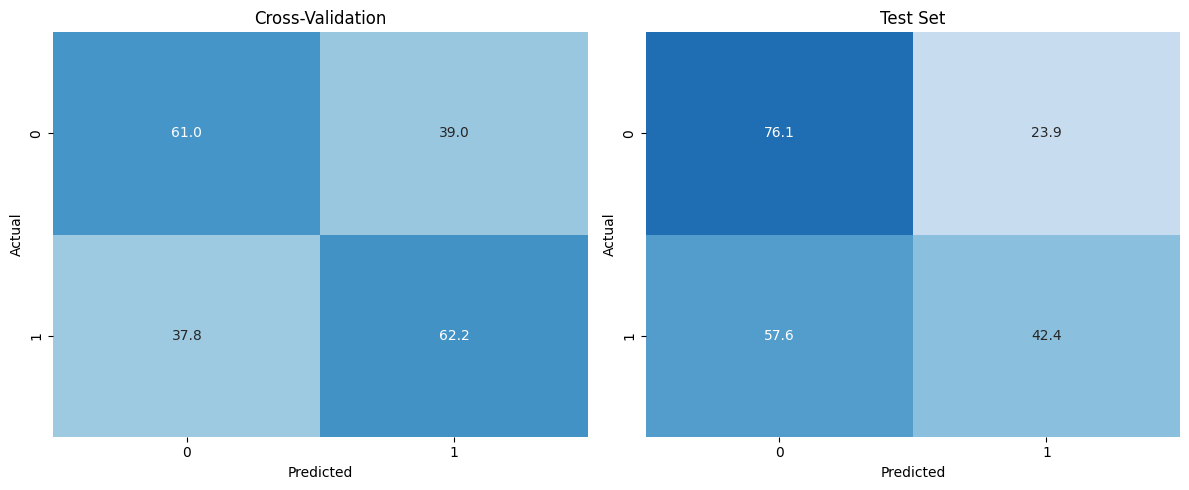

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np


# For binary, if probs are shape (n_samples,), for multi-class shape (n_samples, n_classes)
def to_labels(probs, threshold=0.5):
    if probs.ndim == 1 or probs.shape[1] == 1:  # Binary case
        return (probs >= threshold).astype(int)
    else:  # Multi-class case
        return np.argmax(probs, axis=1)

results = [
    ("Cross-Validation", pooled_true, to_labels(pooled_probs)),
    ("Test Set", y_true_test, to_labels(y_prob_test))
]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for ax, (title, y_true, y_pred) in zip(axes, results):
    cm = confusion_matrix(y_true, y_pred)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
    sns.heatmap(
        cm_percent, annot=True, fmt='.1f', cmap='Blues',
        ax=ax, vmin=0, vmax=100, cbar=False
    )
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()

